# Related to figure 3b

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
df_1 = pd.read_csv('/data/yuchen_data/Stereo_seq/All_Figures/Figure3/1.data/pattern_1_BP.txt', index_col=0, sep='\t')
df_2 = pd.read_csv('/data/yuchen_data/Stereo_seq/All_Figures/Figure3/1.data/pattern_2_BP.txt', index_col=0, sep='\t')

df_1['Gene Ratio'] = [int(x.split('/')[0]) / int(x.split('/')[1]) for x in df_1['GeneRatio']]
df_2['Gene Ratio'] = [int(x.split('/')[0]) / int(x.split('/')[1]) for x in df_2['GeneRatio']]

df_1['-log10p'] = -np.log10(df_1['p.adjust'])
df_2['-log10p'] = -np.log10(df_2['p.adjust'])

df_1

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,Gene Ratio,-log10p
GO:0000377,GO:0000377,"RNA splicing, via transesterification reaction...",42/655,383/18862,4.610416e-11,9.105855e-08,7.593830e-08,DDX5/SNRPE/RBM6/HNRNPD/SFPQ/MFAP1/HNRNPA2B1/HN...,42,0.064122,7.040679
GO:0000398,GO:0000398,"mRNA splicing, via spliceosome",42/655,383/18862,4.610416e-11,9.105855e-08,7.593830e-08,DDX5/SNRPE/RBM6/HNRNPD/SFPQ/MFAP1/HNRNPA2B1/HN...,42,0.064122,7.040679
GO:0000375,GO:0000375,"RNA splicing, via transesterification reactions",42/655,386/18862,5.911613e-11,9.105855e-08,7.593830e-08,DDX5/SNRPE/RBM6/HNRNPD/SFPQ/MFAP1/HNRNPA2B1/HN...,42,0.064122,7.040679
GO:1903311,GO:1903311,regulation of mRNA metabolic process,38/655,334/18862,1.350887e-10,1.560613e-07,1.301473e-07,DDX5/VIM/CNOT6L/HNRNPD/BTG2/UBC/SERBP1/HNRNPA2...,38,0.058015,6.806705
GO:0006283,GO:0006283,transcription-coupled nucleotide-excision repair,17/655,73/18862,3.644551e-10,3.368294e-07,2.808990e-07,RBX1/UBC/ERCC1/POLR2G/RPA2/POLR2A/TCEA1/POLD1/...,17,0.025954,6.472590
...,...,...,...,...,...,...,...,...,...,...,...
GO:0031349,GO:0031349,positive regulation of defense response,23/655,361/18862,3.974409e-03,4.937028e-02,4.117236e-02,PRKDC/HMGB1/STAP1/XRCC6/SKP1/ETS1/HLA-G/HMGB2/...,23,0.035115,1.306534
GO:0006405,GO:0006405,RNA export from nucleus,12/655,142/18862,3.986566e-03,4.938853e-02,4.118758e-02,HNRNPA2B1/DDX39A/NPM1/SRSF3/SRSF9/SRSF7/HNRNPA...,12,0.018321,1.306374
GO:0090559,GO:0090559,regulation of membrane permeability,9/655,90/18862,4.018985e-03,4.954671e-02,4.131949e-02,ATP5IF1/SLC25A5/BAX/MOAP1/YWHAE/BCL2L11/BLOC1S...,9,0.013740,1.304985
GO:0032868,GO:0032868,response to insulin,19/655,278/18862,4.020778e-03,4.954671e-02,4.131949e-02,PRKDC/ATP6V1F/SOS1/PRKCB/SESN3/SH2B2/MZB1/GNAI...,19,0.029008,1.304985


In [5]:
used_items = ['B cell activation','B cell receptor signaling pathway','B cell differentiation','B cell proliferation','oxidative phosphorylation','negative regulation of inflammatory response','negative regulation of lymphocyte proliferation','negative regulation of cytokine production', 'negative regulation of immune effector process']

df_1 = df_1[df_1['Description'].isin(used_items)]
df_2 = df_2[df_2['Description'].isin(used_items)]
df_1 = df_1.iloc[list(range(df_1.shape[0]))[::-1], ]

df_1['x'] = [0]*df_1.shape[0]
df_2['x'] = [0.01]*df_2.shape[0]


df_2['y'] = range(4)
df_1['y'] = range(4, 9)

df_plot = pd.concat((df_1, df_2))

df_plot

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,Gene Ratio,-log10p,x,y
GO:0042100,GO:0042100,B cell proliferation,11/655,96/18862,4.933263e-04,0.013101,0.010926,CD22/CD74/BAX/BTK/MZB1/CD40/BCL6/MS4A1/CD81/LY...,11,0.016794,1.882679,0.00,4
GO:0030183,GO:0030183,B cell differentiation,15/655,137/18862,8.463975e-05,0.003401,0.002836,PRKDC/POU2AF1/BAX/BTK/PLCG2/TPD52/BCL6/MS4A1/S...,15,0.022901,2.468388,0.00,5
GO:0050853,GO:0050853,B cell receptor signaling pathway,20/655,134/18862,3.856122e-08,0.000013,0.000011,PAX5/STAP1/CD22/PRKCB/IGHG3/SH2B2/BAX/BTK/PLCG...,20,0.030534,4.895241,0.00,6
GO:0006119,GO:0006119,oxidative phosphorylation,22/655,148/18862,8.736193e-09,0.000004,0.000003,UQCRB/COX4I1/NDUFB3/ATP5MC2/COX5A/NDUFB11/ATP5...,22,0.033588,5.435335,0.00,7
GO:0042113,GO:0042113,B cell activation,35/655,326/18862,3.437337e-09,0.000002,0.000002,PRKDC/BANK1/POU2AF1/CD22/PRKCB/CD74/IGHG3/BAX/...,35,0.053435,5.702132,0.00,8
GO:0050728,GO:0050728,negative regulation of inflammatory response,13/448,160/18862,1.192472e-04,0.002121,0.001709,NDFIP1/TNFRSF1A/RORA/FFAR4/APOE/SERPINF1/TNFRS...,13,0.029018,2.673556,0.01,0
GO:0001818,GO:0001818,negative regulation of cytokine production,20/448,367/18862,5.273722e-04,0.007287,0.005874,ANXA1/LRRC32/NDFIP1/LEF1/FFAR4/SIGIRR/IDO1/ARR...,20,0.044643,2.137451,0.01,1
GO:0002698,GO:0002698,negative regulation of immune effector process,9/448,125/18862,2.997166e-03,0.027609,0.022255,ANXA1/NDFIP1/SERPING1/ARRB2/FGL2/PGLYRP2/APOA2...,9,0.020089,1.558949,0.01,2
GO:0050672,GO:0050672,negative regulation of lymphocyte proliferation,7/448,81/18862,3.121238e-03,0.028623,0.023072,LRRC32/NDFIP1/IDO1/LILRB2/GPNMB/TYROBP/SDC4,7,0.015625,1.543285,0.01,3


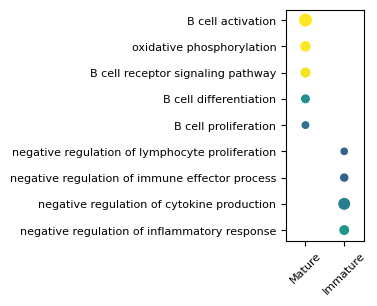

In [6]:

plt.figure(figsize=(1, 3))
plt.scatter(x=df_plot['x'], y=df_plot['y'], s=df_plot['Gene Ratio']*1300, c=df_plot['-log10p'], vmax=5, vmin=0, cmap='viridis')
plt.xlim(-0.005, 0.015)
plt.xticks([0, 0.01], ['Mature', 'Immature'], rotation=45, fontsize=8)
plt.yticks(df_plot['y'], df_plot['Description'], fontsize=8)
plt.show()